<a href="https://colab.research.google.com/github/sugi-san/first-order-model/blob/master/FOMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

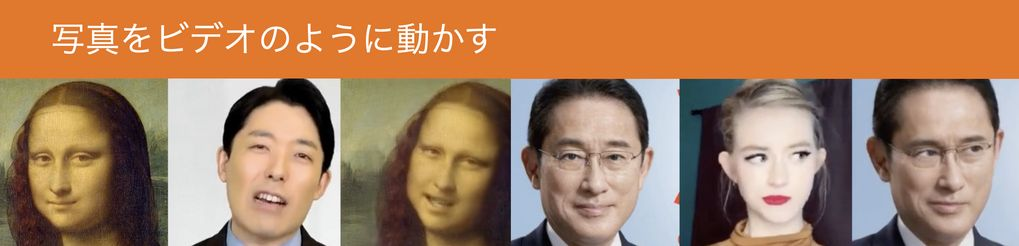

In [ ]:
#@title **1.セットアップ**

# github からコードを取得
!git clone https://github.com/sugi-san/first-order-model.git
%cd first-order-model

# 学習済みパラメータのダウンロード
! pip install --upgrade gdown
import os
import gdown
import time
for i in range(10):
  if os.path.exists('vox-cpk.pth.tar'):
    break
  else:
    gdown.download('https://drive.google.com/uc?id=1eS9u8vWDWmjLmBmLsIimlbY8Sg7FQ0aK', 'vox-cpk.pth.tar', quiet=False)
    time.sleep(1)


# ランドマークデータのダウンロード
! wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
! bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

# 関数定義
from function import *

# downloadフォルダ作成
import os
os.makedirs('examples/download')

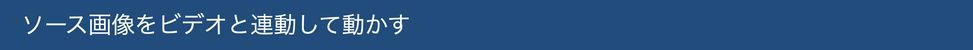

In [ ]:
#@title **2.ソースとビデオの表示**

# --- 画像表示 ---
print('=== source ===')
display_pic('examples/source')

# --- 動画表示 ---
print('=== video ===')
reset_folder('examples/pic_video')
import glob
files = sorted(glob.glob('examples/video/*.mp4'))
names = []
for file in files:
  name = os.path.basename(file)
  save_frame(name, 'examples/video', 'examples/pic_video')
  names.append(name)
display_movie('examples/pic_video', names)


In [ ]:
#@title **3.動画の作成** 

import imageio
import numpy as np
import matplotlib.animation as animation
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")

from demo import load_checkpoints
from demo import make_animation
from skimage import img_as_ubyte

source = '01.jpg' #@param {"type": "string"}
video = '04.mp4' #@param {"type": "string"}

source_image = imageio.imread('./examples/source/'+source)
driving_video = imageio.mimread('./examples/video/'+video)

#Resize image and video to 256x256
source_image = resize(source_image, (256, 256))[..., :3]
driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]


generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                            checkpoint_path='vox-cpk.pth.tar')

predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)
#HTML(display(source_image, driving_video, predictions).to_html5_video())

import cv2
import numpy as np

reset_folder('images')
reset_folder('images2')

for i in range(len(predictions)):
    source_img = (source_image * 255).astype(np.uint8)
    drive = (driving_video[i] * 255).astype(np.uint8)
    predict = (predictions[i] * 255).astype(np.uint8)

    # 横長
    tmp = cv2.hconcat([source_img, drive])
    img = cv2.hconcat([tmp, predict])
    imageio.imwrite('images/'+str(i).zfill(6)+'.jpg', img)

    # スクエア
    black = cv2.imread('black.jpg')
    up = cv2.hconcat([black, source_img])
    down = cv2.hconcat([drive, predict])
    all = cv2.vconcat([up, down])
    imageio.imwrite('images2/'+str(i).zfill(6)+'.jpg', all)

# フレームレート取得
video_file = './examples/video/'+video
cap = cv2.VideoCapture(video_file)
fps = cap.get(cv2.CAP_PROP_FPS)

# 動画作成
print('making movie...')
! ffmpeg -y -r $fps -i images/%06d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error out.mp4
! ffmpeg -y -r $fps -i images2/%06d.jpg -vcodec libx264 -pix_fmt yuv420p -loglevel error out2.mp4

# 音声抽出・付加
print('preparation for sound...')
! ffmpeg -y -i $video_file -loglevel error sound.mp3
! ffmpeg -y -i out.mp4 -i sound.mp3 -loglevel error output.mp4
! ffmpeg -y -i out2.mp4 -i sound.mp3 -loglevel error output2.mp4

# 画像の再生
display_mp4('output.mp4')

In [ ]:
#@title **4.動画のダウンロード**

#@markdown ・正方形にしたい場合は、squareにチェックを入れて下さい

import shutil
source_name = os.path.splitext(source)
video_name = os.path.splitext(video)

square = False #@param {type:"boolean"}

if square == True:
  download_name = 'examples/download/'+source_name[0]+'_'+video_name[0]+'s.mp4'
  shutil.copy('output2.mp4', download_name)
else:
  download_name = 'examples/download/'+source_name[0]+'_'+video_name[0]+'b.mp4'
  shutil.copy('output.mp4', download_name)

from google.colab import files
files.download(download_name)

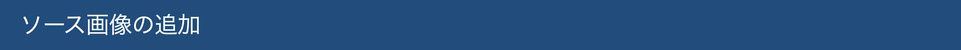

In [ ]:
#@title **5.画像のアップロード**

# ルートへ画像をアップロード
from google.colab import files
reset_folder('pic')
uploaded = files.upload()           
uploaded = list(uploaded.keys())    

# ルートから指定フォルダーへ移動
for file in uploaded:
    shutil.move(file, 'pic')

display_pic('pic')

In [ ]:
#@title **6.顔の切り出し**
import os
import shutil
from tqdm import tqdm

reset_folder('align')

def run_alignment(image_path):
  import dlib
  from alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  return aligned_image 
 
path = './pic'
files = sorted(os.listdir(path))
for i, file in enumerate(tqdm(files)):
  if file=='.ipynb_checkpoints':
     continue
  input_image = run_alignment(path+'/'+file)
  input_image.resize((1024,1024))
  input_image.save('./align/'+file)
 
display_pic('align')

In [ ]:
#@title **7.ソースへ追加**
add = '' #@param {type:"string"}

import shutil
shutil.copy('align/'+add, 'examples/source/'+add)

###【備考】
・ブラウザは、必ずGoogle Chromeを使用して下さい。

・動作がおかしくなった場合の対応\
１）グーグルクロームの該当タブを削除して接続を切る\
２）再度リンクを開く\
３）右上にある「ランタイム／ランタイムを出荷時設定にリセット」をクリックする（下記写真を参照に下さい）\
４）あとは、動画にある通りの操作をすればOK

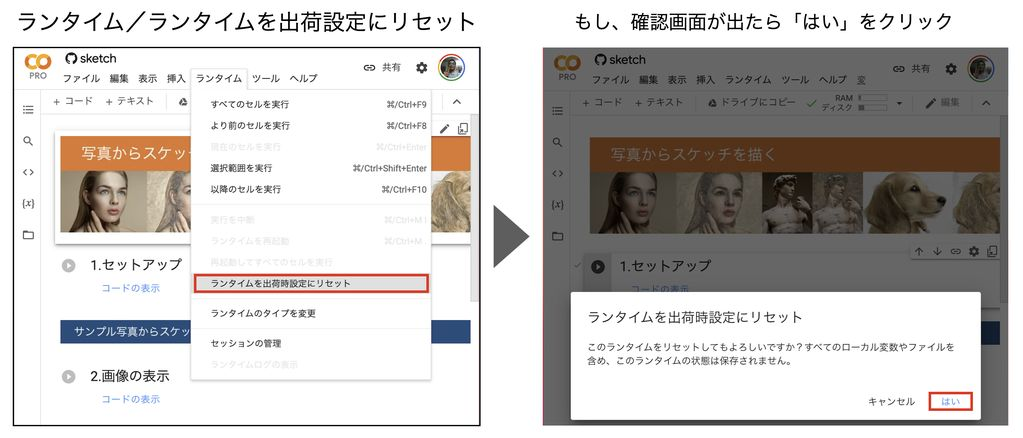